# Import libraries 

In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

SEED = 42

# Load data

In [2]:
df = pd.read_csv('../data/Parameters_90%stability.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
X_train = pd.read_csv('../data/x_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test = pd.read_csv('../data/x_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

## Normalize data

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize(X_train, X_test):
    scaler = StandardScaler()
#     scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

X_train, X_test = normalize(X_train, X_test)

# SelectKBest

In [4]:
select_class = SelectKBest(f_classif, k=20)
select_class.fit(X_train, y_train)
X_train_new = select_class.transform(X_train)
new_df = df.drop('Stability',axis=1).iloc[:,select_class.get_support()]
new_df.columns.values
selectkbest_features = new_df.columns.values
selectkbest_features

array(['Gamma_ACACT1r', 'Gamma_ALCD2irm', 'Gamma_ANS', 'Gamma_ASPTA',
       'Gamma_ACN_a_m', 'Gamma_G6PDH2r', 'Gamma_GLUSx', 'Gamma_GF6PTA',
       'Gamma_IG3PS', 'Gamma_AKGDbm', 'Gamma_PHETA1', 'Gamma_PSERT',
       'Gamma_PHETRA', 'Gamma_CITtbm', 'Gamma_ASNt2r', 'Gamma_ACALDtm',
       'Gamma_HCO3E', 'Gamma_ALAtmi', 'Gamma_ACONTm', 'Gamma_CBPt'],
      dtype=object)

# Tree-based approach

In [5]:
def feature_importance(model, graph):
    model.fit(X_train, y_train)

    feats = {} # a dict to hold feature_name: feature_importance
    
    for feature, importance in zip(df.drop(columns='Stability').columns, model.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Feature Importance'})
    
    # HOW MANY BEST "FEATURES?"
    print(importances.sort_values(by='Feature Importance').tail(20))
    if(graph):
        importances.sort_values(by='Feature Importance').tail(20).plot(kind='bar', rot=45, figsize=(25, 25))
        plt.show()
        
    return importances.sort_values(by='Feature Importance').tail(20)

In [6]:
rf_features = feature_importance(RandomForestClassifier(), 0)

                                        Feature Importance
sigma_km_product31_LMPD_s_0450_c_1_256            0.004945
Gamma_GF6PTA                                      0.005157
Gamma_CSm                                         0.005598
sigma_km_product2_HSTPT                           0.005824
sigma_km_product1_IGPS                            0.005953
Gamma_H2Ot                                        0.006383
Gamma_MDHm                                        0.006747
Gamma_FBA                                         0.007042
sigma_km_product2_ALCD26xi                        0.007123
Gamma_2PHETOHtm                                   0.007235
Gamma_AKGDbm                                      0.007255
sigma_km_substrate_NADHtrm                        0.007336
Gamma_GLXt                                        0.007339
Gamma_MDH                                         0.007688
Gamma_CITtbm                                      0.009304
Gamma_VALTA                                       0.0095

In [7]:
dct_features = feature_importance(DecisionTreeClassifier(), 0)

                              Feature Importance
Gamma_TYRTRA                            0.018294
Gamma_TRPTA                             0.018294
sigma_km_substrate_GLCt1                0.018294
sigma_km_substrate1_ILETA               0.021388
sigma_km_product_OAAt2m                 0.021953
sigma_km_substrate2_GK1                 0.023332
sigma_km_substrate2_PHETRA              0.023683
sigma_km_product2_ICDHym                0.023963
sigma_km_product2_ASPTA                 0.024248
sigma_km_product2_2OXOADPTm             0.027442
Gamma_6PGCt6                            0.027442
sigma_km_substrate_VALt5m               0.032669
sigma_km_product_E4Ptm                  0.032930
sigma_km_product2_GLUDy                 0.036403
sigma_km_product2_ASPTAm                0.046752
sigma_km_product2_SUCFUMtm              0.063306
sigma_km_substrate1_AKGMALtm            0.082716
sigma_km_substrate1_GUAPRT              0.083145
sigma_km_product2_AKGMAL                0.134397
Gamma_PYNP2r        

# XGBoost

In [8]:
from xgboost import XGBClassifier

xgb_features = feature_importance(XGBClassifier(eval_metric='logloss'), 0)

                                          Feature Importance
sigma_km_substrate18_LMPD_s_0450_c_1_256            0.012942
sigma_km_substrate_VALt5m                           0.014285
sigma_km_product6_THZPSN2_SC                        0.014443
sigma_km_product1_ACCOAC                            0.014482
sigma_km_product1_HEMEOSm                           0.015382
sigma_km_product2_ICDHym                            0.017070
sigma_km_substrate2_TKT2                            0.017075
sigma_km_substrate2_MALS                            0.018085
sigma_km_substrate2_IPPS                            0.020386
sigma_km_substrate2_ICDHxm                          0.023376
sigma_km_product2_PRFGS                             0.024425
sigma_km_product1_MGSA                              0.025277
sigma_km_product2_GF6PTA                            0.025924
sigma_km_product2_ASPTAm                            0.027528
Gamma_IPPSm                                         0.032267
sigma_km_product2_SUCFUM

# Boruta

!pip install boruta

In [9]:
from boruta import BorutaPy

forest = RandomForestClassifier(random_state=SEED)
feat_selector = BorutaPy(forest, n_estimators='auto', 
                         verbose=2, random_state=SEED)
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1410
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	1297
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	1297
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	1297
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	1297
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	92
Rejected: 	1317
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	92
Rejected: 	1317
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	92
Rejected: 	1317
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	92
Rejected: 	1317
Iteration: 	16 / 100
C

BorutaPy(estimator=RandomForestClassifier(n_estimators=96,
                                          random_state=RandomState(MT19937) at 0x7FFA1EE3F140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FFA1EE3F140, verbose=2)

In [10]:
# check selected features
print(feat_selector.support_)

# check ranking of features
print(feat_selector.ranking_)

X_filtered = feat_selector.transform(X_train)
print(X_filtered.shape)

bor_feat = pd.DataFrame(feat_selector.support_, columns=['keep'])
bor_feat['col'] = df.drop('Stability',axis=1).columns.values
bor_feat['score'] = feat_selector.ranking_

print(bor_feat[bor_feat['keep']==True])

[False False False ... False False False]
[ 197 1049   42 ...  369 1239  738]
(260, 15)
      keep                         col  score
50    True                 Gamma_IG3PS      1
207   True               Gamma_ALATA_L      1
432   True    sigma_km_product2_AKGMAL      1
466   True  sigma_km_product2_ALCD26xi      1
539   True     sigma_km_substrate_ATPM      1
574   True     sigma_km_product1_CHORS      1
722   True    sigma_km_product2_GF6PTA      1
745   True   sigma_km_substrate1_GLUDy      1
748   True     sigma_km_product2_GLUDy      1
822   True     sigma_km_product2_HSTPT      1
840   True    sigma_km_product1_ICDHxm      1
841   True  sigma_km_substrate2_ICDHxm      1
1037  True    sigma_km_substrate2_MALS      1
1163  True       sigma_km_product2_PFK      1
1324  True  sigma_km_product2_SUCFUMtm      1


# Information gain

Estimate mutual information for a discrete target variable.

**Mutual information (MI)** between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

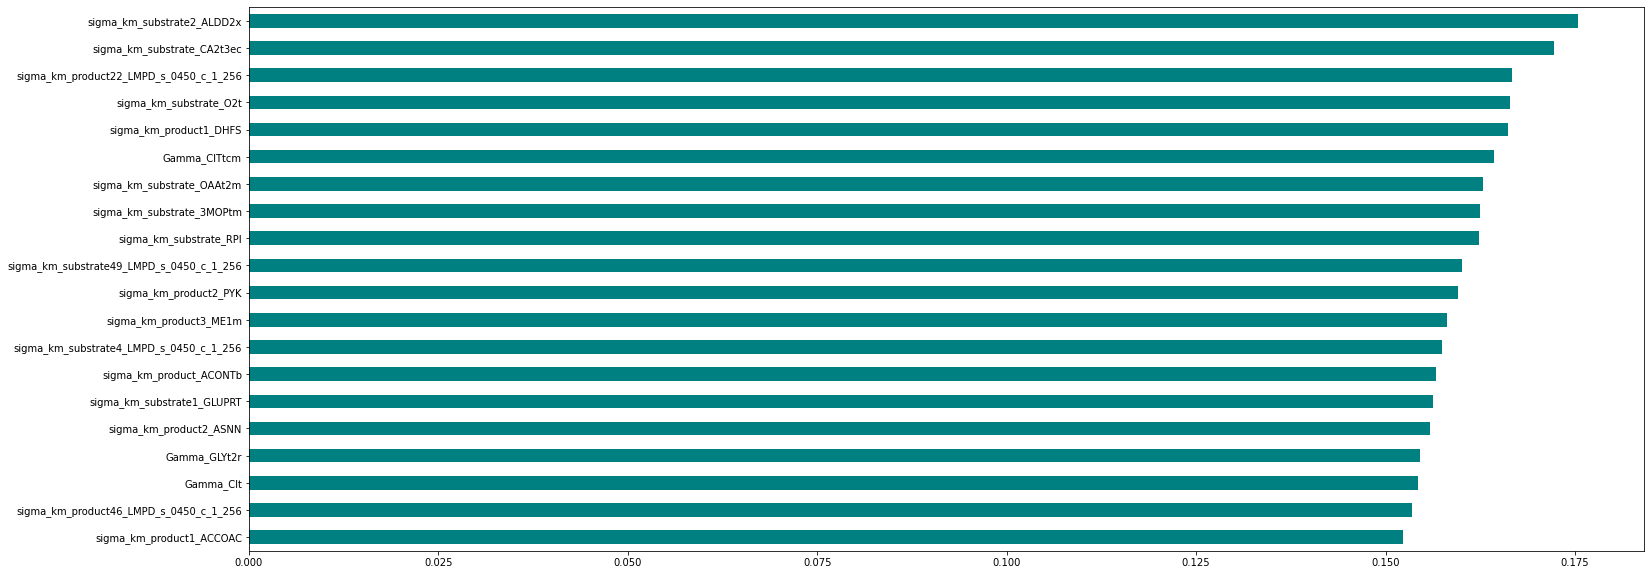

In [11]:
from sklearn.feature_selection import mutual_info_classif

importance = mutual_info_classif(X_train, y_train)
feat_importance = pd.Series(importance, df.columns[0: len(df.columns)-1])
feat_importance = feat_importance.sort_values()
feat_importance.tail(20).plot(kind='barh', color='teal', figsize=(25,10))
plt.show()

# feat_importance = pd.DataFrame(importance, columns=['mi_score'])
# feat_importance['col'] = df.drop('Stability',axis=1).columns.values
# feat_importance = feat_importance.sort_values(by='mi_score')
# feat_importance

# Backward Feature Elimination:

!pip install mlxtend

Transformer that performs Sequential Feature Selection.

This **Sequential Feature Selector** adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator. In the case of unsupervised learning, this Sequential Feature Selector looks only at the features (X), not the desired outputs (y).

In [12]:
# %%time

# from sklearn.svm import SVC
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.feature_selection import SequentialFeatureSelector

# sbs = SequentialFeatureSelector(SVC(), n_features_to_select=None, 
#                                 direction='backward', n_jobs=-1, scoring='roc_auc')
# sbs.fit(X_train, y_train.values.ravel())
# sbs.k_feature_names_

# Compare selection of different methods

In [13]:
bor_feat[bor_feat['keep']==True]['col'].values

array(['Gamma_IG3PS', 'Gamma_ALATA_L', 'sigma_km_product2_AKGMAL',
       'sigma_km_product2_ALCD26xi', 'sigma_km_substrate_ATPM',
       'sigma_km_product1_CHORS', 'sigma_km_product2_GF6PTA',
       'sigma_km_substrate1_GLUDy', 'sigma_km_product2_GLUDy',
       'sigma_km_product2_HSTPT', 'sigma_km_product1_ICDHxm',
       'sigma_km_substrate2_ICDHxm', 'sigma_km_substrate2_MALS',
       'sigma_km_product2_PFK', 'sigma_km_product2_SUCFUMtm'],
      dtype=object)

In [14]:
rf_features.T.columns.values

array(['sigma_km_product31_LMPD_s_0450_c_1_256', 'Gamma_GF6PTA',
       'Gamma_CSm', 'sigma_km_product2_HSTPT', 'sigma_km_product1_IGPS',
       'Gamma_H2Ot', 'Gamma_MDHm', 'Gamma_FBA',
       'sigma_km_product2_ALCD26xi', 'Gamma_2PHETOHtm', 'Gamma_AKGDbm',
       'sigma_km_substrate_NADHtrm', 'Gamma_GLXt', 'Gamma_MDH',
       'Gamma_CITtbm', 'Gamma_VALTA', 'Gamma_ASNt2r', 'Gamma_GLUDC',
       'Gamma_ORNTA', 'Gamma_ICDHyr'], dtype=object)

In [15]:
xgb_features.T.columns.values

array(['sigma_km_substrate18_LMPD_s_0450_c_1_256',
       'sigma_km_substrate_VALt5m', 'sigma_km_product6_THZPSN2_SC',
       'sigma_km_product1_ACCOAC', 'sigma_km_product1_HEMEOSm',
       'sigma_km_product2_ICDHym', 'sigma_km_substrate2_TKT2',
       'sigma_km_substrate2_MALS', 'sigma_km_substrate2_IPPS',
       'sigma_km_substrate2_ICDHxm', 'sigma_km_product2_PRFGS',
       'sigma_km_product1_MGSA', 'sigma_km_product2_GF6PTA',
       'sigma_km_product2_ASPTAm', 'Gamma_IPPSm',
       'sigma_km_product2_SUCFUMtm', 'sigma_km_product2_AKGMAL',
       'sigma_km_substrate1_AKGMALtm', 'sigma_km_substrate1_GUAPRT',
       'Gamma_GLUDC'], dtype=object)

In [16]:
dct_features.T.columns.values

array(['Gamma_TYRTRA', 'Gamma_TRPTA', 'sigma_km_substrate_GLCt1',
       'sigma_km_substrate1_ILETA', 'sigma_km_product_OAAt2m',
       'sigma_km_substrate2_GK1', 'sigma_km_substrate2_PHETRA',
       'sigma_km_product2_ICDHym', 'sigma_km_product2_ASPTA',
       'sigma_km_product2_2OXOADPTm', 'Gamma_6PGCt6',
       'sigma_km_substrate_VALt5m', 'sigma_km_product_E4Ptm',
       'sigma_km_product2_GLUDy', 'sigma_km_product2_ASPTAm',
       'sigma_km_product2_SUCFUMtm', 'sigma_km_substrate1_AKGMALtm',
       'sigma_km_substrate1_GUAPRT', 'sigma_km_product2_AKGMAL',
       'Gamma_PYNP2r'], dtype=object)

In [17]:
selectkbest_features

array(['Gamma_ACACT1r', 'Gamma_ALCD2irm', 'Gamma_ANS', 'Gamma_ASPTA',
       'Gamma_ACN_a_m', 'Gamma_G6PDH2r', 'Gamma_GLUSx', 'Gamma_GF6PTA',
       'Gamma_IG3PS', 'Gamma_AKGDbm', 'Gamma_PHETA1', 'Gamma_PSERT',
       'Gamma_PHETRA', 'Gamma_CITtbm', 'Gamma_ASNt2r', 'Gamma_ACALDtm',
       'Gamma_HCO3E', 'Gamma_ALAtmi', 'Gamma_ACONTm', 'Gamma_CBPt'],
      dtype=object)

### RandomForest - XGBoost

In [18]:
x=rf_features.T.columns.values
y=xgb_features.T.columns.values
print(np.intersect1d(x, y)) 

['Gamma_GLUDC']


### RandomForest - DecisionTree

In [19]:
x=rf_features.T.columns.values
y=dct_features.T.columns.values
print(np.intersect1d(x, y)) 

[]


### DecisionTree - XGBoost

In [20]:
x=dct_features.T.columns.values
y=xgb_features.T.columns.values
print(np.intersect1d(x, y)) 

['sigma_km_product2_AKGMAL' 'sigma_km_product2_ASPTAm'
 'sigma_km_product2_ICDHym' 'sigma_km_product2_SUCFUMtm'
 'sigma_km_substrate1_AKGMALtm' 'sigma_km_substrate1_GUAPRT'
 'sigma_km_substrate_VALt5m']


### DecisionTree - Boruta

In [21]:
x=dct_features.T.columns.values
y=bor_feat[bor_feat['keep']==True]['col'].values
print(np.intersect1d(x, y)) 

['sigma_km_product2_AKGMAL' 'sigma_km_product2_GLUDy'
 'sigma_km_product2_SUCFUMtm']


 ### Boruta - XGBoost

In [22]:
x=xgb_features.T.columns.values
y=bor_feat[bor_feat['keep']==True]['col'].values
print(np.intersect1d(x, y)) 

['sigma_km_product2_AKGMAL' 'sigma_km_product2_GF6PTA'
 'sigma_km_product2_SUCFUMtm' 'sigma_km_substrate2_ICDHxm'
 'sigma_km_substrate2_MALS']


### Boruta - RandomForest

In [23]:
x=rf_features.T.columns.values
y=bor_feat[bor_feat['keep']==True]['col'].values
print(np.intersect1d(x, y)) 

['sigma_km_product2_ALCD26xi' 'sigma_km_product2_HSTPT']


### SelectKBest - DecisionTree

In [24]:
x=selectkbest_features
y=dct_features.T.columns.values
print(np.intersect1d(x, y)) 

[]


### SelectKBest - RandomForest

In [25]:
x=selectkbest_features
y=rf_features.T.columns.values
print(np.intersect1d(x, y)) 

['Gamma_AKGDbm' 'Gamma_ASNt2r' 'Gamma_CITtbm' 'Gamma_GF6PTA']


### SelectKBest - XGBoost

In [26]:
x=selectkbest_features
y=xgb_features.T.columns.values
print(np.intersect1d(x, y)) 

[]


### SelectKBest - Boruta

In [27]:
x=selectkbest_features
y=bor_feat[bor_feat['keep']==True]['col'].values
print(np.intersect1d(x, y)) 

['Gamma_IG3PS']
